#Clustering/Cluster Analysis

Going through some of the techniques discussed in lectures.

In [72]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from math import sqrt

#This sets up plotting
%pylab inline
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

data = pd.read_pickle("./data_frames/clean_data.pkl")

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


##K-Means

One of the biggest issues with K-Means is setting the value of K. Here, we attempt to overcome this limitation by using the "kink" or "elbow" method to identify a suitable value for K.

This is done as follows:
* Choose a range of target values for K.
* Cluster the data using each target value. Save the final value of the cost function (here denoted as W).
* Plot the value of K (x axis) vs the final cost function (y axis).
* Choose the value of K where the plot "levels out", which is taken as an indication that this is a good approximation of the number of clusters.
* Note that as K approaches the number of data points, W will tend to 0. This is why we look for the point at which W levels out, rather than a global minimum.

In [73]:
from sklearn.cluster import KMeans

#Choose a range of target values/init empty list for target function values
k_values = range(1, len(data.index))
w_values = []

#Specify the data we want to cluster
categories = {
    "land_utilisation":(
        ["land_use"],
        [col for col in data["land_use"] if (col[-3:] == "pct")]
    ),
    "wealth_gap":(
        ["socio_demographic"],
        ["pct_household_income_less_600_week", 
         "pct_personal_income_less_400_week", 
         "isrd_score_avg", "unemployed", 
         "pct_persons_dnc_year_12"]
    ),
    "population_age_diversity":(
        ["diversity", "2012_population"],
        [["aboriginal_tsi_persons",
          "born_overseas",
          "born_non_english_speaking_country",
          "speak_lote_at_home",
          "persons_poor_english"],
         [col for col in data["2012_population"] 
          if (col not in ["total_persons"]) and (col[-3:] != "pct")]]
    )
}

#This sets the measure we'll be working with
measure = "wealth_gap"

#Pull out the features
features = []
if len(categories[measure][0]) > 1:
    for i in range(0, len(categories[measure][0])):
        features += [(categories[measure][0][i], col) for col in categories[measure][1][i]]
else:
    features = [(categories[measure][0][0], col) for col in categories[measure][1]]

In [74]:
#Iteratively compute w for each value of k
for k in k_values:
    km = KMeans(n_clusters=k)    
    km.fit(data[features].fillna(0))
    w_values.append(km.inertia_)

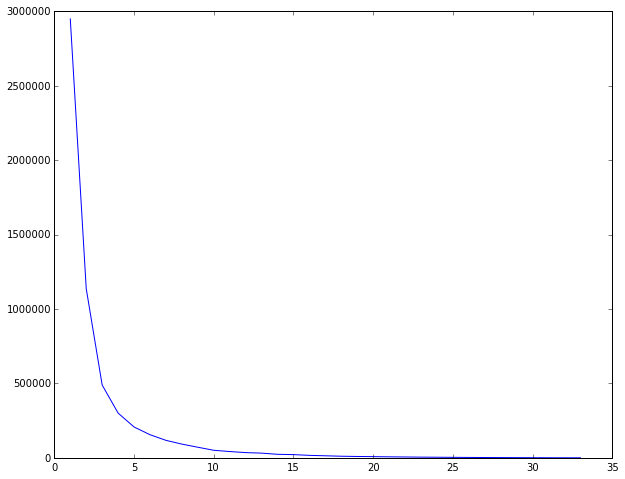

In [75]:
#Plot the values
plt.plot(k_values, w_values)

The ideal value for k should be somewhere around the "kink" or "elbow" of the graph.

In [76]:
km = KMeans(n_clusters=5)

feature_set = pd.DataFrame(data[features].fillna(0))
feature_set["cluster"] = km.fit_predict(feature_set)

In [77]:
feature_set["cluster"]

ascot_vale           3
braybrook            3
craigieburn          2
croydon              1
fawkner              3
footscray            1
glenroy              1
malvern_east         1
malvern              0
melbourne_airport    4
mentone              0
moorabbin            4
mordialloc           0
murrumbeena          0
noble_park           2
north_melbourne      1
northcote            1
parkville            3
pascoe_vale_south    0
port_melbourne       0
prahran              0
somerville           0
sorrento             4
south_melbourne      0
south_yarra          1
springvale           2
st_andrews_beach     4
st_kilda_east        0
st_kilda             1
st_kilda_west        4
toorak               0
tyabb                4
waterways            4
windsor              0
Name: cluster, dtype: int32

##Cluster Visualisation via Manifold Learning

To get a better idea of what our clusters actually look like, let's attemp to visualise them using a dimensionality reduction technique.

In [78]:
from sklearn.manifold import Isomap

In [79]:
isomap = Isomap(n_components=2)

In [80]:
reduced = pd.DataFrame(isomap.fit_transform(feature_set), index=feature_set.index, columns=["x", "y"])
reduced["cluster"] = feature_set["cluster"]

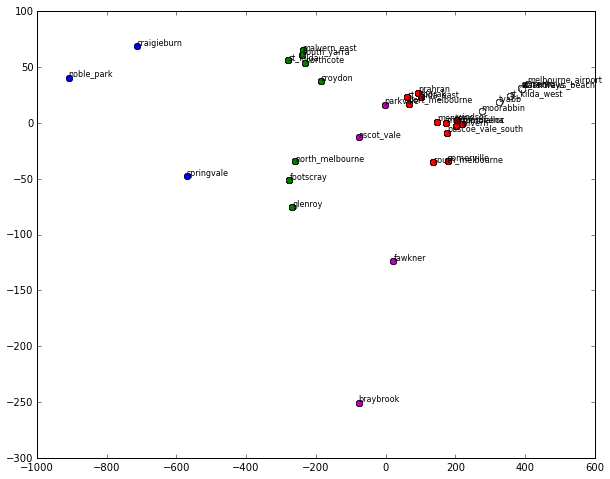

In [81]:
#Label the clusters
for place in reduced.index:
    plt.annotate(
        place, (
            reduced.loc[place]["x"] + 1, 
            reduced.loc[place]["y"] + 1
        ), size=8
    )

#Styling params for clusters
styling = {
    0:"ro",
    1:"go",
    2:"bo",
    3:"mo",
    4:"wo",
    5:"yo",
    6:"co",
    7:"ko",
    8:"w*",
    9:"w^",
}

#Plot it
for cluster in reduced["cluster"]:
    plt.plot(
        reduced[reduced["cluster"] == cluster]["x"], 
        reduced[reduced["cluster"] == cluster]["y"],
        styling[cluster]
    )
#plt.savefig("2012_population_manifold.png")

##Cluster Visualisation via PCA

More visualisation, this time using PCA.

In [59]:
from sklearn.decomposition import PCA

In [60]:
pca = PCA(n_components=2)

In [61]:
reduced = pd.DataFrame(pca.fit_transform(feature_set), index=feature_set.index, columns=["x", "y"])
reduced["cluster"] = feature_set["cluster"]

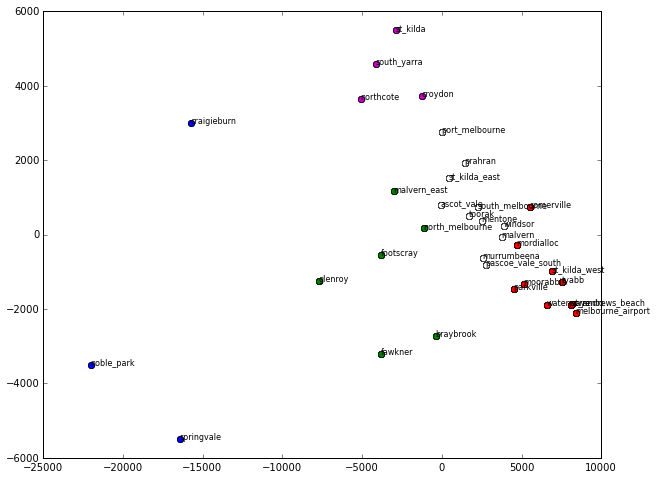

In [62]:
#Label the clusters
for place in reduced.index:
    plt.annotate(
        place, (
            reduced.loc[place]["x"], 
            reduced.loc[place]["y"] - 5
        ), size=8
    )

styling = {
    0:"ro",
    1:"go",
    2:"bo",
    3:"mo",
    4:"wo",
    5:"yo",
    6:"co",
    7:"ko",
    8:"w*",
    9:"w^",
}

#Plot it
for cluster in reduced["cluster"]:
    plt.plot(
        reduced[reduced["cluster"] == cluster]["x"], 
        reduced[reduced["cluster"] == cluster]["y"],
        styling[cluster]
    )

##Dimensionality Reduction via Similarity Metric

Now we'll attempt to reduce the dimensionality using a distance metric. Going on what we saw above, population does a pretty good job of clumping areas into distinct regions. Therefore we'll define the distance between two suburbs in terms of the Euclidean distance between the vectors comprising their population counts.

In [63]:
#Sets up the input data
feature_set = data[features]

In [64]:
#Defines the euclidean distance between two vectors a and b
def euclidean(a, b):
    return sum( sqrt((ai - bi)**2) for ai,bi in zip(a,b) )

#Defines the cosine similarity between two vectors a and b
def vector_norm(a):
    return sqrt(sum(ai**2 for ai in a))

def dot_product(a, b):
    return sum([ai*bi for ai,bi in zip(a,b)])

def cosine(a, b):
    return dot_product(a, b) / (vector_norm(a) * vector_norm(b))

In [65]:
#Creates a pair-wise distance matrix form the input data
euclidean_distances = pd.DataFrame(
    index=feature_set.index,
    columns=feature_set.index,
    dtype=float
).fillna(0.0)

for suburb in feature_set.index:
    u = feature_set.loc[suburb]
    for compare_to in [sub for sub in feature_set.index if sub != suburb]:
        v = feature_set.loc[compare_to]
        #We take the inverse sqaure root to make Perren's thing work better
        euclidean_distances.loc[suburb][compare_to] = euclidean(u, v)

#Creates a pair-wise distance matrix form the input data
cosine_distances = pd.DataFrame(
    index=feature_set.index,
    columns=feature_set.index,
    dtype=float
).fillna(0.0)

for suburb in feature_set.index:
    u = feature_set.loc[suburb]
    for compare_to in [sub for sub in feature_set.index if sub != suburb]:
        v = feature_set.loc[compare_to]
        #We take the inverse sqaure root to make Perren's thing work better
        cosine_distances.loc[suburb][compare_to] = cosine(u, v)
        

##Comparing Similarity With Distance

Now we can pull some actual distances from Google maps and compare them against the distances plotted above. There's a script called google_distances.py that creates a dataframe in ./data_frames with all the distances in it. We can load this directly in.

In [66]:
actual_distances = pd.read_pickle("./data_frames/google_distances.pkl")

In [67]:
#Converts a distance matrix into a list of distance triples - (source, destination, distance)
def distance_triple(dataframe):
    distances = []
    for source,destinations in dataframe.to_dict().items():
        for destination,distance in destinations.items():
            if destination != source:
                distances.append((source, destination, distance))
    return distances

In [68]:
actual_distances = distance_triple(actual_distances)
euclidean_distances = distance_triple(euclidean_distances)
cosine_distances = distance_triple(cosine_distances)

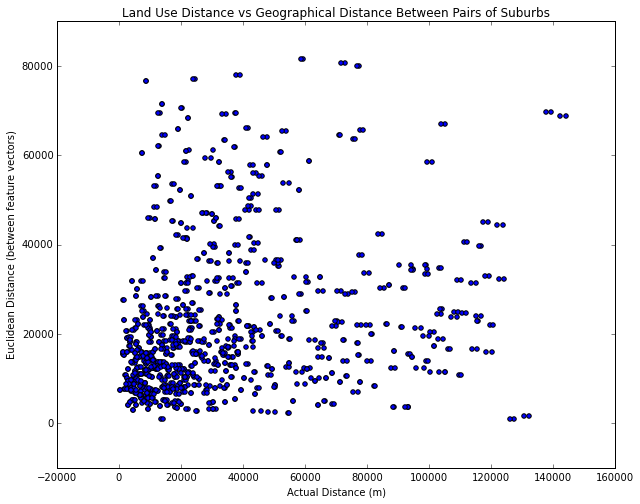

In [69]:
plt.xlabel("Actual Distance (m)")
plt.ylabel("Euclidean Distance (between feature vectors)")
plt.title("Land Use Distance vs Geographical Distance Between Pairs of Suburbs", size=12)

plt.scatter(
    [dist[2] for dist in actual_distances],
    [dist[2] for dist in euclidean_distances],
)

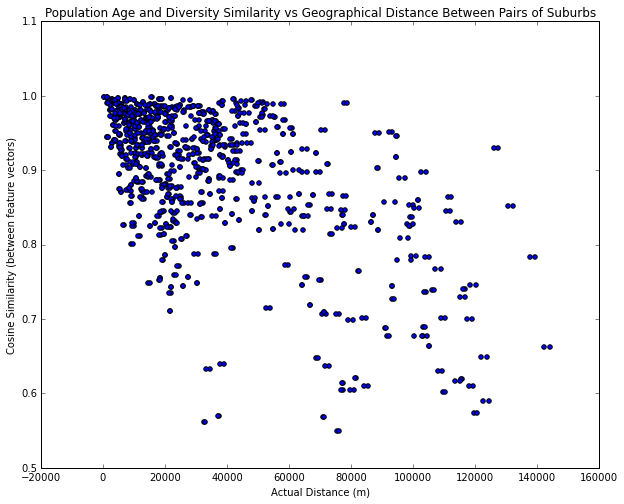

In [71]:
plt.xlabel("Actual Distance (m)")
plt.ylabel("Cosine Similarity (between feature vectors)")
plt.title("Population Age and Diversity Similarity vs Geographical Distance Between Pairs of Suburbs", size=12)

plt.scatter(
    [dist[2] for dist in actual_distances],
    [dist[2] for dist in cosine_distances],
)

No obvious correlation exists. Conclusion is that distance is in no way indicative of how demographically similar two suburbs are?

In [48]:
#Edges exist between each place in the data set
edges = [
    (a,b) 
    for a in distances.index
    for b in distances.index
    if b != a
]

#Edges are weighted by distance
weighted_edges = []
for item in edges:
    c = distances.loc[item[0]][item[1]]
    if(c < 10000):
        weighted_edges.append((item[0], item[1], 1))

NameError: name 'distances' is not defined

In [19]:
#Perren's graph visualization thing
import networkx as nx

#edge are a tuple (from, to, weight)
def generateGraphSansPositionWithWeights(edges):
    plt.close()
    myGraph = nx.Graph()
    
    for item in edges:
        myGraph.add_edge(item[0], item[1], weight=item[2])
    
    graph_pos = nx.spring_layout(myGraph)
    label_pos = {
        label:[coords[0], coords[1]-0.05] 
        for label,coords in graph_pos.items()
    }
    
    nx.draw_networkx_labels(
        myGraph,
        label_pos,
        font_size=10,
        font_family='sans-serif',
        font_color="blue"
    )
    nx.draw(
        myGraph,
        graph_pos,
        edge_color="white",
        node_color="yellow"
    )
   
    return myGraph

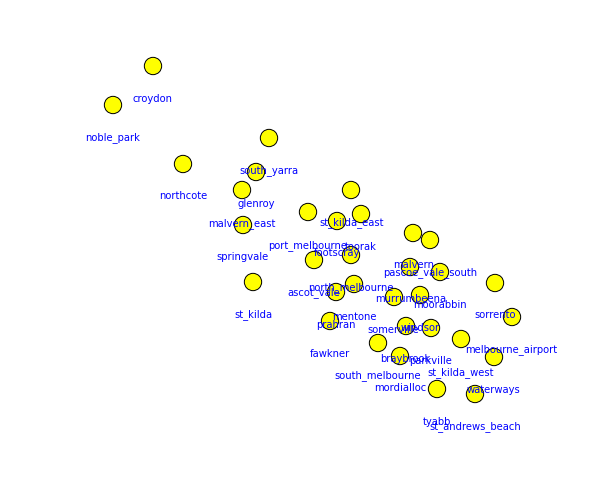

In [222]:
generateGraphSansPositionWithWeights(weighted_edges)

In [223]:
#This mess sorts out Geographic similarity somehow
clusterBasedOnHospital = {}
i = 0
sc = 3
for item in v:
    vdirection = (0,0)
    vstring = data["Location"][i]
    #print vstring
    for dir in vstring.split()[1]:
        if(dir == 'W'):
            vdirection = (vdirection[0] - 1, vdirection[1])
        if(dir == 'E'):
            vdirection = (vdirection[0] + 1, vdirection[1])
        if(dir == 'N'):
            vdirection = (vdirection[0], vdirection[1] + 1)
        if(dir == 'S'):
            vdirection = (vdirection[0], vdirection[1] - 1)
    #print vdirection
    nsum = math.sqrt(vdirection[0] ** 2 + vdirection[1] ** 2)
    vdirection = (vdirection[0]/nsum, vdirection[1]/nsum)
    if(clusterBasedOnHospital.has_key(item)):
        clusterBasedOnHospital[item].append((names[i], data["DistFromMelbourne(Km)"][i], vdirection, data["Travel time to nearest public hospital"][i]))
        #if(clusterBasedOnHospital.has_key(data["Nearest public hospital with maternity services"][i])):
        #    x = (names[i], data["DistFromMelbourne(Km)"][i], vdirection, data["Time to nearest public hospital with maternity services"][i] ** sc)
        #    bo = False
        #    for values in clusterBasedOnHospital[data["Nearest public hospital with maternity services"][i]]:
        #        if(x[0] == values[0]):
        #            bo = True
        #    if(not bo):
        #        clusterBasedOnHospital[data["Nearest public hospital with maternity services"][i]].append(x)
        else:
        #    x = (names[i], data["DistFromMelbourne(Km)"][i], vdirection, data["Time to nearest public hospital with maternity services"][i] ** sc)
        #   
        #    bo = False
        #    for values in clusterBasedOnHospital[data["Nearest public hospital with maternity services"][i]]:
        #        if(x[0] == values[0]):
        #            bo = True
        #    if(not bo):
        #        clusterBasedOnHospital[data["Nearest public hospital with maternity services"][i]] = [x]
    else:
        clusterBasedOnHospital[item] = [(names[i], data["DistFromMelbourne(Km)"][i], vdirection, data["Travel time to nearest public hospital"][i])]
        #if(clusterBasedOnHospital.has_key(data["Nearest public hospital with maternity services"][i])):
        #    x =(names[i], data["DistFromMelbourne(Km)"][i], vdirection, data["Time to nearest public hospital with maternity services"][i] ** sc)
        #    bo = False
        #    for values in clusterBasedOnHospital[data["Nearest public hospital with maternity services"][i]]:
        #        if(x[0] == values[0]):
        #            bo = True
        #    if(not bo):
        #        clusterBasedOnHospital[data["Nearest public hospital with maternity services"][i]].append(x)
        #    else:
        #        x = (names[i], data["DistFromMelbourne(Km)"][i], vdirection, data["Time to nearest public hospital with maternity services"][i] ** sc)
        #        clusterBasedOnHospital[data["Nearest public hospital with maternity services"][i]] = [x]    
    i += 1

for item in clusterBasedOnHospital:
    vpl = 0
    ppl = (0, 0)
    for itemv in clusterBasedOnHospital[item]:
        vpl += itemv[1]
        ppl = ((ppl[0] + itemv[2][0] ​* (1/(itemv[3]))), (ppl[1] + itemv[2][1]*​ (1/(itemv[3]))) )
    nsum = math.sqrt(ppl[0] ** 2 + ppl[1] ** 2)
    ppl = (ppl[0]/nsum, ppl[1]/nsum)
    vpl = (vpl / len(clusterBasedOnHospital[item]))
    print item, ',', vpl, ',', ppl[0], ',', ppl[1], ',', len(clusterBasedOnHospital[item]), ' '
    for item2 in clusterBasedOnHospital[item]:
        print "\t", item2[0].split()[0], item2[3], item2[1], item2[2]

SyntaxError: invalid syntax (<ipython-input-223-0bd390b22c48>, line 31)